<a href="https://colab.research.google.com/github/Alphver/SinGAN/blob/master/GAN_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import necessary library

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras import layers
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import os
import datetime
import numpy as np

import PIL 


In [ ]:
def denorm_int(x):
  return tf.cast((x+1.0)*127.5,tf.int8)

In [ ]:
def denorm_float(x):
  return (x+1.0)/2.0

Conv block

In [ ]:
def convBlock(filters, size, stride, norm = "batch_norm", activation="lrelu",padd="valid"):
  initializer = tf.random_normal_initializer(0., 0.02)
  #initializer = tf.keras.initializers.GlorotNormal()
  result = tf.keras.Sequential()
  if padd == "none":   
    result.add(tf.keras.layers.Conv2D(filters, size, stride, kernel_initializer=initializer))
  elif padd =="valid":    
    result.add(tf.keras.layers.Conv2D(filters, size, stride, padding='valid', kernel_initializer=initializer))


  if norm == "batch_norm":
    result.add(tf.keras.layers.BatchNormalization())
  elif norm == "instance_norm":
    result.add(tfa.layers.InstanceNormalization())
  elif norm == "none":
    pass
  else:
    print("parameter error")   
  
  if activation == "lrelu":
    result.add(tf.keras.layers.LeakyReLU(0.2))
  elif activation == "tanh":
    result.add(tf.keras.layers.Activation('tanh'))
  elif activation == "none":
    pass
  else:
    print("parameter error")

  return result

Generator model

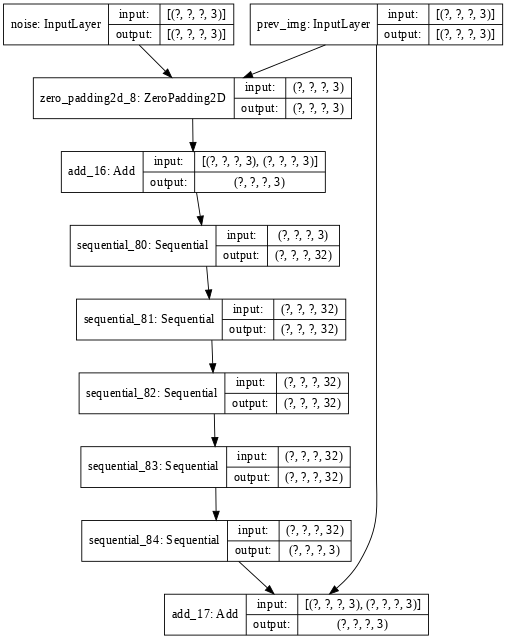

In [ ]:
def create_generator(cur_scale):
  filter_num = 32
  pad = tf.keras.layers.ZeroPadding2D(5)

  prev_img = tf.keras.layers.Input(shape=[None,None,3],name="prev_img")
  noise = tf.keras.layers.Input(shape=[None,None,3],name="noise")
  pad_prev_img = pad(prev_img)
  pad_noise = pad(noise)

  x = tf.keras.layers.Add()([pad_prev_img, pad_noise])
  for i in range(4):
    x = convBlock(filter_num, 3, 1)(x)
  
  x = convBlock(3, 3, 1, norm="none",activation="tanh")(x)
  x = tf.keras.layers.Add()([prev_img,x])

  return tf.keras.Model(inputs=[prev_img, noise], outputs=x)

#unit testing
g = create_generator(6)
tf.keras.utils.plot_model(g, show_shapes=True, dpi=64)
#g.save("generator.h5")

Discriminator model

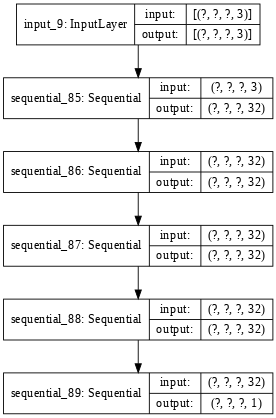

In [ ]:
def create_discriminator(cur_scale):
  filter_num = 32
  img = tf.keras.layers.Input(shape=[None,None,3])
  x = img

  for i in range(4):
    x = convBlock(filter_num, 3, 1)(x)

  x = convBlock(1, 3, 1,norm = "none",activation="none")(x)

  return tf.keras.Model(inputs=img, outputs=x)

#unit testing
d = create_discriminator(6)
tf.keras.utils.plot_model(d, show_shapes=True, dpi=64)
#d.save("discriminator.h5")

Load image

In [ ]:
#return rescaled and [-1,1] float value image
def load_and_preprocess(image_path):
  max_size = 400
  init_scale_factor = 0.75
  image = PIL.Image.open(image_path).convert("RGB")
  image = tf.keras.preprocessing.image.img_to_array(image)
  image = tf.dtypes.cast(image, tf.float32)
  max_length = max(image.shape[0],image.shape[1])
  if max_length > max_size:
    resize_factor = max_size/max_length
    resize_h = tf.cast(image.shape[0]*resize_factor, tf.int16)
    resize_w = tf.cast(image.shape[1]*resize_factor, tf.int16)
    image = tf.image.resize(image, [resize_h, resize_w],antialias=True)
  #normalize the image value to [-1,1]
  image = (image / 127.5) - 1.0
  
  return image
#x = load_and_preprocess("cows.png")

In [ ]:
#return 255 float value image
def load_image(image_path):
  image = PIL.Image.open(image_path).convert("RGB")
  image = tf.keras.preprocessing.image.img_to_array(image)
  return image

In [ ]:
def calc_scale_and_factor(image):
  #init parameters
  init_factor = 0.75
  min_size = 25

  #decide the shorter length of image
  short_length = min(image.shape[0],image.shape[1])

  #step 1: calc approximate scale number
  scale = tf.math.floor(tf.math.log(min_size/short_length)/tf.math.log(init_factor))

  #step2: according to the scale number, calculate the scale factor
  factor = tf.math.pow((min_size/short_length),1/scale)

  #return int(scale+1), factor
  return 6, 0.75

#image = load_and_preprocess("night.jpg")
#sca ,fa = calc_scale_and_factor(image)

Create downsamples

In [ ]:
def create_downsamples(image, scale,scale_factor):
  MIN_IMAGE_SIZE = 25
  downsample_images = []
  image_h, image_w = image.shape[0], image.shape[1]
  for cur_scale in range(scale):
    resize_image_h = max(int(image_h * pow(scale_factor,cur_scale)),MIN_IMAGE_SIZE) 
    resize_image_w = max(int(image_w * pow(scale_factor,cur_scale)),MIN_IMAGE_SIZE)
    
    resize_image = tf.image.resize(image, [resize_image_h, resize_image_w],antialias=True)
    resize_image = tf.expand_dims(resize_image,0)
    downsample_images.append(resize_image)
  
  downsample_images.reverse()
  for cur_scale in range(scale):
    print("scale: ", cur_scale, "shape:",downsample_images[cur_scale].shape)

  return downsample_images

#x = load_and_preprocess("cows.png")
#y = create_downsamples(x,7)

gradient penalty

In [ ]:
def gradient_penalty(dnet, real, gen_img):
  epsilon = tf.random.uniform(shape=[1],maxval=1.0)
  interpolation = epsilon * real + (1 - epsilon) * gen_img
  with tf.GradientTape() as t:
      t.watch(interpolation)
      interpolation_score = dnet(interpolation)
  gradients = t.gradient(interpolation_score, interpolation)
  gradient_per_pixel = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[3]))
  gp = tf.reduce_mean((gradient_per_pixel - 1.0) ** 2)
  return gp

Inference part

In [ ]:
#generate random samples at generate_scale, return generated image with shape(height,width,3)
def random_sample(trainer, generate_scale=0 ):
  prev_ = tf.zeros_like(trainer.real_images[0])
  for i in range(trainer.num_scale):
    if i <  generate_scale:
      noise = trainer.noise_rec[i]*trainer.noise_amp[i]
    if i >= generate_scale:
      noise = tf.random.normal(trainer.real_images[i].shape,0,0.2)
      noise = noise * trainer.noise_amp[i]
    prev_ = trainer.gnets[i]([prev_, noise])
    if i != trainer.num_scale - 1:
      prev_ = tf.image.resize(prev_,[trainer.real_images[i+1].shape[1],trainer.real_images[i+1].shape[2]])
  img = denorm_float(prev_)
  #plt.imshow(img[0])
  return img[0]

In [ ]:
#inject an image at generate_scale, return generated image with shape(height,width,3)
def inject_image(trainer, inject_image_path, generate_scale=1):
  inject_image = load_image(inject_image_path)
  inject_image = (inject_image/127.5)-1.0
  if generate_scale ==0:
    print("ERROR, generate scale is not allowed to be 0 in image manipulation task ")
    return 0
  else:
    shape = trainer.real_images[generate_scale].shape
    inject_image = tf.image.resize(inject_image,[shape[1],shape[2]])
    prev_ = tf.expand_dims(inject_image,0)
  for i in range(trainer.num_scale):
    if i >= generate_scale:
      noise = tf.random.normal(trainer.real_images[i].shape,0,0.2)
      noise = noise * trainer.noise_amp[i]
      #noise = trainer.noise_rec[i]*trainer.noise_amp[i]

      prev_ = trainer.gnets[i]([prev_, noise])
      if i != trainer.num_scale - 1:
        prev_ = tf.image.resize(prev_,[trainer.real_images[i+1].shape[1],trainer.real_images[i+1].shape[2]])
  img = denorm_float(prev_)
  #plt.imshow(img[0])
  return img[0]

Main train

In [ ]:
class main_train:
  def __init__(self):
    self.EPOCHS = 2001
    self.D_STEP = 3
    self.G_STEP = 3
    self.ALPHA = 0.1
    self.BETA = 10.0
    self.dnets = []
    self.gnets = []
  
  def preprocess(self,image_path):
    self.file_name = image_path
    image = load_and_preprocess(image_path)
    self.num_scale, self.scale_factor = calc_scale_and_factor(image)
    self.real_images = create_downsamples(image,self.num_scale,self.scale_factor)


  def init_model(self):
    for scale in range(self.num_scale):
      dnet = create_discriminator(scale)
      gnet = create_generator(scale)
      self.dnets.append(dnet)
      self.gnets.append(gnet)
    self.noise_amp = [0. for i in range(self.num_scale)]
    self.noise_rec = [0. for i in range(self.num_scale)]
    
  def save_model(self,scale):
    d_dir = f'weight/{self.file_name}/d/{scale}'
    g_dir = f'weight/{self.file_name}/g/{scale}'

    self.dnets[scale].save_weights(d_dir, save_format='tf')
    self.gnets[scale].save_weights(g_dir, save_format='tf')

  def train_timer(self,last_time):
    cur_time = datetime.datetime.now()
    interval = (cur_time - last_time).seconds
    interval_in_minute = interval/60.0
    return interval_in_minute

  def load_model(self,scale):
    if scale%4 != 100:
      self.dnets[scale].load_weights(f'weight/{self.file_name}/d/{scale-1}')
      self.gnets[scale].load_weights(f'weight/{self.file_name}/g/{scale-1}')

  def train(self,image_path):
    #timer
    start_time = datetime.datetime.now()

    #load image and calculate scale, factor, and downsamole
    self.preprocess(image_path)
    self.init_model()

    for cur_scale in range(self.num_scale):
      scale_start_time = datetime.datetime.now()
      #------training--------
      self.train_single_scale(cur_scale)
      self.save_model(cur_scale)
      #------end-------------
      interval = self.train_timer(scale_start_time)
      print(f"finish training scale {cur_scale}, used time: {interval}")
    amp_dir = f'weight/{self.file_name}/amp'
    rec_dir = f'weight/{self.file_name}/rec'
    np.save(amp_dir, self.noise_amp)
    np.save(rec_dir, self.noise_rec[0])
    interval = self.train_timer(start_time)
    print("used time: ", interval)
    self.train_status = True

  def inference(self, inject_image_path, mode, generate_scale):
    if mode == "pure":
      random_sample(self,generate_scale)
    elif mode == "inject":
      inject_image(self,inject_image_path,generate_scale)

  def train_single_scale(self,cur_scale):    
    #network parameter
    lr = tf.keras.optimizers.schedules.ExponentialDecay(5e-4, decay_steps=4800, decay_rate=0.1, staircase=True)
    #lr_d = tf.keras.optimizers.schedules.ExponentialDecay(5e-4, decay_steps=1600, decay_rate=0.1, staircase=True)


    g_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5, beta_2 = 0.999)
    d_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5, beta_2 = 0.999)
    if cur_scale != 0:
      self.load_model(cur_scale)
     
    real_image = self.real_images[cur_scale]

    for epoch in range(self.EPOCHS):
      #noise_rec, prev_rec, noise_amp
      if cur_scale == 0:
        self.noise_rec[cur_scale] = tf.random.normal(real_image.shape,0,0.2)
        prev_rec = tf.zeros_like(real_image)
        prev_img = tf.zeros_like(real_image)
        self.noise_amp[cur_scale]= 1.0
      else:
        self.noise_rec[cur_scale] = tf.zeros_like(real_image)
        prev_rec = self.generate_prev_img(cur_scale,"rec")
        prev_img = self.generate_prev_img(cur_scale,"img")
        if epoch ==0:
          RMSE = tf.math.sqrt(tf.reduce_mean(tf.square(real_image - prev_rec)))
          self.noise_amp[cur_scale] = 0.1 * RMSE
      
      #prev_img, noise
      noise = tf.random.normal(real_image.shape,0,0.2)
      noise = noise * self.noise_amp[cur_scale]

      
      #----------------------------
      #training discriminator
      for step in range(self.D_STEP):
        with tf.GradientTape() as disc_tape:
          fake_image = self.gnets[cur_scale]([prev_img,noise])
          d_real_score = tf.reduce_mean(self.dnets[cur_scale](real_image))
          d_fake_score = tf.reduce_mean(self.dnets[cur_scale](fake_image))
          d_adv_loss = d_fake_score - d_real_score
          gp = gradient_penalty(self.dnets[cur_scale],real_image,fake_image)
          d_loss = d_adv_loss + self.ALPHA * gp

        d_grad = disc_tape.gradient(d_loss,self.dnets[cur_scale].trainable_variables)
        d_optimizer.apply_gradients(zip(d_grad,self.dnets[cur_scale].trainable_variables))
      
      
      #----------------------------
      #training generator
      for step in range(self.G_STEP):
        with tf.GradientTape() as gen_tape:
          fake_image = self.gnets[cur_scale]([prev_img,noise])
          fake_rec = self.gnets[cur_scale]([prev_rec,self.noise_rec[cur_scale]])
          g_real_score = tf.reduce_mean(self.dnets[cur_scale](real_image))
          g_fake_score = tf.reduce_mean(self.dnets[cur_scale](fake_image))
          g_adv_loss = -g_fake_score
          rec_loss = tf.reduce_mean(tf.square(fake_rec - real_image))
          g_loss = g_adv_loss + self.BETA * rec_loss
        
        g_grad = gen_tape.gradient(g_loss,self.gnets[cur_scale].trainable_variables)
        g_optimizer.apply_gradients(zip(g_grad,self.gnets[cur_scale].trainable_variables))

      shown_loss = tf.reduce_mean(tf.square(fake_image - real_image))

      if epoch % 100 ==0:
        print("epoch:  ",epoch)
        print("d_real_score:        ",d_real_score)
        print("d_fake_score:        ",d_fake_score)
        #print("grad_penalty:        ",self.ALPHA * gp)
        #print("d_loss:              ",d_loss)

        print("g_real_score:        ",g_real_score)
        print("g_fake_score:        ",g_fake_score)
        print("rec_loss:            ",rec_loss)
        print("exact loss:          ",shown_loss)
        #print("g_loss:              ",g_loss)
          
    return 1



  def generate_prev_img(self, cur_scale,mode):
    #when cur_scale == 0
    prev_ = tf.zeros_like(self.real_images[0])
    if mode == "rec":
      for i in range(cur_scale):
        noise = self.noise_rec[i] * self.noise_amp[i]
        prev_ = self.gnets[i]([prev_, noise])
        prev_ = tf.image.resize(prev_,[self.real_images[i+1].shape[1],self.real_images[i+1].shape[2]])
    
    elif mode == "img":
      for i in range(cur_scale):
        noise = tf.random.normal(self.real_images[i].shape,0,0.2)
        noise = noise * self.noise_amp[i]
        prev_ = self.gnets[i]([prev_, noise])
        prev_ = tf.image.resize(prev_,[self.real_images[i+1].shape[1],self.real_images[i+1].shape[2]])
    
    return prev_

Training single image

In [ ]:
trainer = main_train()
trainer.train("6_wheat_field_vangogh.jpg")

Batch training

In [ ]:
"""
def batch_train(file_list):
  for name in file_list:
    trainer = main_train()
    trainer.train(name)
    source = f'weight/{trainer.file_name}'
    des = f'drive/My\ Drive/new_weight400/{trainer.file_name}'
    print(source, des)
    !cp -r $source $des

file_list = ['example.jpg','balloons.png','sea.jpg']
batch_train(file_list)
"""

Inferencer

In [ ]:
def save_img(image,path):
  image *= 255.0
  image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255.0)
  image = PIL.Image.fromarray(np.array(image).astype(np.uint8).squeeze())
  image.save(path)

In [ ]:
#this code is copied from SinGAN and modified.
from skimage import color, morphology, filters
def dilate_mask(mask,mode):
    if mode == "harmonization":
        element = morphology.disk(radius=1)
    if mode == "editing":
        element = morphology.disk(radius=20)
    mask = mask[:,:,0]
    mask = morphology.binary_dilation(mask,selem=element)
    mask = filters.gaussian(mask, sigma=5)
    mask = tf.expand_dims(mask,2)
    return mask

In [ ]:
#loader use to load weight and parametes from trained model
def create_loader(img_path):
  loader = main_train()
  #load num_scale, scale_factor, real_images
  loader.preprocess(img_path)
  #load gnet, noise_amp
  loader.init_model()
  for scale in range(loader.num_scale):
    loader.gnets[scale].load_weights(f'weight/{loader.file_name}/g/{scale}')
  amp_dir = f'weight/{loader.file_name}/amp.npy'
  loader.noise_amp = np.load(amp_dir)
  #load noise_rec
  rec_dir = f'weight/{loader.file_name}/rec.npy'
  loader.noise_rec[0] = tf.convert_to_tensor(np.load(rec_dir))
  for scale in range(1,loader.num_scale):
    loader.noise_rec[scale] = tf.zeros_like(loader.real_images[scale])
  
  return loader

In [ ]:
def main_inference(mode,img_path,inject_path,mask_path,num_sample):
  loader = create_loader(img_path)
  dir_path = f'generated_image/{loader.file_name}/{mode}'
  if not os.path.exists(dir_path):
    os.makedirs(dir_path)
  if mode == "random":
    for i in range(num_sample):
      result = random_sample(loader,0)
      save_path = dir_path+f'/sample:{i}.jpg'
      save_img(result,save_path)
      plt.imshow(result)
  elif mode == "low_random":
    for start_scale in range(1,loader.num_scale):
      result = random_sample(loader,start_scale)
      save_path = dir_path+ f'/scale:{start_scale}.jpg'
      save_img(result,save_path)
      plt.imshow(result)
  elif mode == "paint":
    for start_scale in range(1,loader.num_scale):
      result = inject_image(loader,inject_path,start_scale)
      save_path = dir_path+f'/scale:{start_scale}.jpg'
      save_img(result,save_path)
      plt.imshow(result)
  elif mode == "harmonization" or mode =="editing":
    for start_scale in range(1,loader.num_scale):
      real = loader.real_images[-1]
      real = denorm_float(real[0])
      mask = load_image(mask_path)
      mask = dilate_mask(mask,mode)
      mask = tf.image.resize(mask,[real.shape[0],real.shape[1]],antialias = True)
      fake = inject_image(loader,inject_path,start_scale)
      result = mask * fake + (1-mask) * real
      save_path = dir_path+f'/scale:{start_scale}.jpg'
      save_img(result,save_path)
      plt.imshow(result)
  else:
    print("mode parameter wrong")

Inference instance

In [ ]:
"""
First para:   It determines the mode of inference. It has random, low_random, paint, harmonization, and editing.
Second para:  It is the the relative path of the training image.
Third para:   It is the relative path of the injected image. It is used in the paint, harmonization, and editing mode.
Fourth para:  It is the relative path of the masked injected image. It is used in the harmonization, and editing mode.
Fivth para:   It determines the amount of generated image in random mode.
"""
main_inference("random","wheat_field_vangogh.jpg",None,None,20)

In [ ]:
#cp -r generated_image drive/My\ Drive/sxsxsx

remaining things(useless)

In [ ]:
#check ge erated image at each scale
def generate_scale(trainer,scale): 
  prev_ = trainer.generate_prev_img(scale,"img")
  noise = tf.random.normal(trainer.real_images[scale].shape,0,0.2)
  noise = noise * trainer.noise_amp[scale]
  prev_ = trainer.gnets[scale]([prev_, noise])
  prev_ = (prev_ + 1.0)/2.0
  plt.imshow(prev_[0])

generate_scale(trainer,1)